<a href="https://colab.research.google.com/github/ssuzana/Machine-Learning-Notebooks/blob/main/Face_Recognition_with_PCA_and_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition with PCA and SVM


## Imports

In [58]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

## Dataset Info

* We will use the Labeled Faces in the Wild (LFW) people dataset from scikit-learn. 

> See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html.

* It consists of more than 13,000 curated face images of more than 5,000 public figures. 

In [15]:
# load classes with at least 60 samples 
faces = fetch_lfw_people(min_faces_per_person=60)

In [37]:
n_samples, height, width = faces.images.shape
(n_samples, height, width)

(1348, 62, 47)

In [38]:
X = faces.data
y = faces.target

n_features = X.shape[1]
target_names = faces.target_names
n_classes = target_names.shape[0]

print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

n_samples: 1348
n_features: 2914
n_classes: 8


The dataset contains 1348 samples and each sample has 2914 features/dimensions. It has 8 classes.

## Explore the data

In [31]:
for i in range(n_classes):
   print(f'Class {i} has {(y == i).sum()} samples.')

Class 0 has 77 samples.
Class 1 has 236 samples.
Class 2 has 121 samples.
Class 3 has 530 samples.
Class 4 has 109 samples.
Class 5 has 71 samples.
Class 6 has 60 samples.
Class 7 has 144 samples.


Let’s plot a few of these faces:

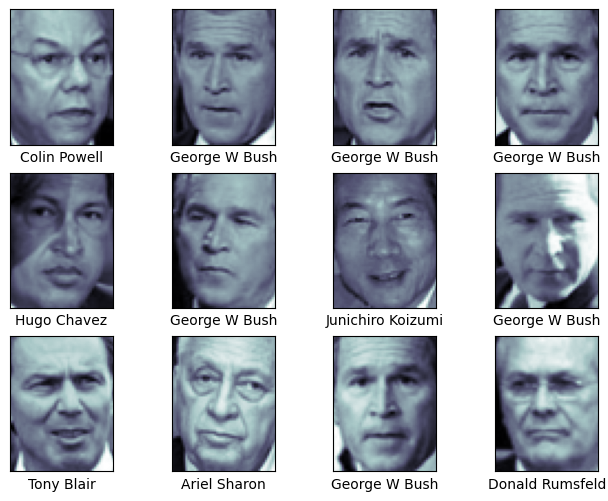

In [29]:
fig, ax = plt.subplots(3, 4, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
  axi.imshow(faces.images[i], cmap='bone')
  axi.set(xticks=[], 
          yticks=[], 
          xlabel=faces.target_names[faces.target[i]])
plt.show() 

## Split data into a training set and a test test

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Compress input features with PCA

Each image contains 62 × 47 = 2914 pixels. We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features.

We will use principal component analysis (PCA) to extract 150 fundamental components to feed into our support vector machine classifier. 

In [49]:
pca = PCA(n_components=150, svd_solver="randomized", whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((150, height, width))

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [51]:
len(eigenfaces)

150

Let’s plot a few of these (creepy) "eigenfaces":

In [55]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

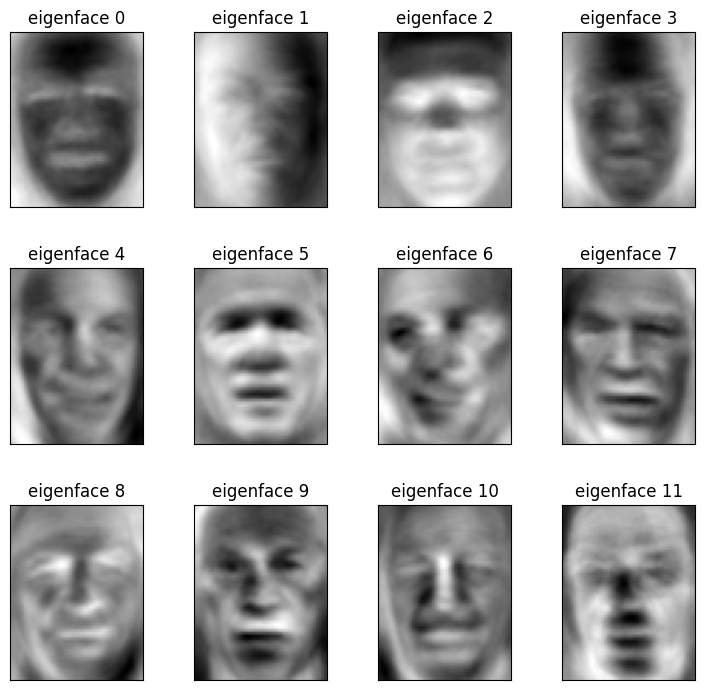

In [57]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width);

## Train a SVM classification model

We can use grid search cross-validation to explore combinations of parame‐ ters. Here we will adjust `C` (which controls the margin hardness) and `gamma` (which controls the size of the radial basis function kernel), and determine the best model:

In [ ]:
# param_grid = {'svc__C': [1, 5, 10, 50],
#               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
# grid = GridSearchCV(model, param_grid)

In [61]:
param_grid = {
    #"C": loguniform(1e3, 1e5),
    "C": [1, 5, 10, 50],
    #"gamma": loguniform(1e-4, 1e-1),
    "gamma":[0.0001, 0.0005, 0.001, 0.005],
}
svc = SVC(kernel="rbf", class_weight="balanced")
clf = RandomizedSearchCV(svc, param_grid, n_iter=10)
clf = clf.fit(X_train_pca, y_train)

In [62]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=5, class_weight='balanced', gamma=0.001)


Note that the optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum. 

Alternatively, we could sample the values for `C` and `gamma` from a `loguniform` distribution.

## Model evaluation on the test set

In [65]:
model = clf.best_estimator_
y_pred = model.predict(X_test_pca)

Let’s take a look at a few of the test images along with their predicted values:

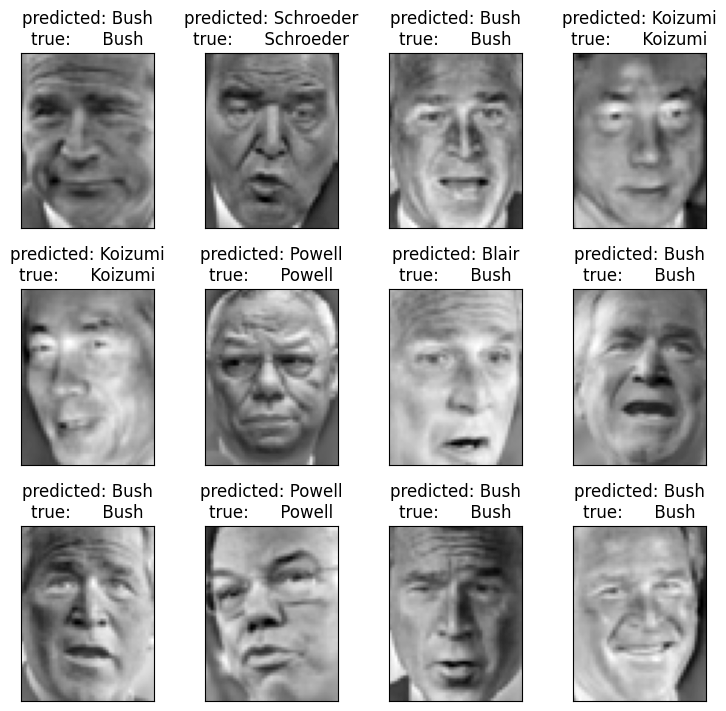

In [67]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, height, width)

We can get a better sense of our estimator’s performance using the classification report, which lists recovery statistics label by label:

In [71]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.76      0.87      0.81        15
     Colin Powell       0.82      0.90      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.82      0.89       126
Gerhard Schroeder       0.78      0.78      0.78        23
      Hugo Chavez       0.82      0.70      0.76        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.95      0.88        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



We display the confusion matrix between these classes. This helps us get a sense of which labels are likely to be confused by the estimator.

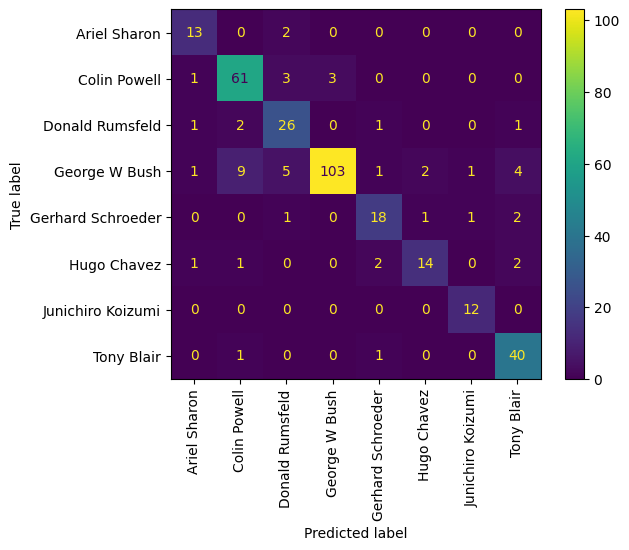

In [74]:
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_pca, y_test, display_labels=target_names, xticks_rotation="vertical"
);

## Notes on real-world facial recognition task


* For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation. For this kind of application, one good option is to make use of `OpenCV`, which, among other things, includes pretrained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

* Face recognition problem would be much more effectively solved by training convolutional neural networks. Interested readers should instead try to use [PyTorch](https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-train-model) or [TensorFlow](https://www.tensorflow.org/tutorials/images/cnn) to implement such models.



## References:

* https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html#sphx-glr-auto-examples-applications-plot-face-recognition-py.

* [Python Data Science Handbook - Second Edition, by Jake VanderPlas](https://www.oreilly.com/library/view/python-data-science/9781098121211/)

* [Python Machine Learning By Example - Third Edition, by Yuxi (Hayden) Liu](https://www.packtpub.com/product/python-machine-learning-by-example-third-edition/9781800209718)